In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split as tts


#import cleaned data
data_set = pd.read_csv('clean_data.csv', header=0)

# #import data schema
# data_schema = pd.read_csv('./cleaned_HCMST_2017_schema.csv', header=0, index_col=0)
# data_set

In [2]:
#definite functions to convert the data set into the format used for EDA
def create_met_places(df):
    r_soc, p_soc = [], []
    places = df.columns[list(df.columns).index('R_cowork')::]
    p_cols = df[places].copy()
    p_cols = p_cols.replace({'yes': 1, 'no': 0})
    #use idxmax to identify 'yes' i.e. 1
    p_cols = p_cols.idxmax(axis=1).copy()
    df.insert(loc=df.shape[1], column='places_met', value=pd.Series(p_cols))
    #aggregate respondent, partner and intermediate social scenarios as 'social circle'
    for item in list(df['places_met'].unique()):
        if "R_" in item:
            r_soc.append(item)
        elif "P_" in item:
            p_soc.append(item)
    for i in range(len(r_soc)):
        df = df.replace({'places_met': {r_soc[i]: 'R_soc_circle'}})
        df = df.replace({'places_met': {p_soc[i]: 'P_soc_circle'}})
    #'customer' should be added to R_soc_circle
    df = df.replace({'places_met': {'customer': 'R_soc_circle'}})
    return df

def fix_household_inc(df):
    hh_labels = df['Household_Income'].unique()
    #leave out the first (<$5,000) and last elements ($250,000), create a dictionary for the middle elements
    inc_dict = {}
    for l in hh_labels:
        if ' to ' in l:
            k = int(l[0:l.find(' to ',0)].replace('$','').replace(',',''))
            inc_dict[l] = k
    inc_dict_val = sorted(list(inc_dict.values()))
    for l in hh_labels:
        if ' to ' in l:
            inc_dict[l] = inc_dict_val.index(inc_dict[l]) + 1
    inc_dict['Less than $5,000'] = 0
    inc_dict['$250,000 or more'] = len(hh_labels) - 1
    df = df.replace({'Household_Income': inc_dict})
    #create feature 'Household_Income2'
    hh_inc2 = df['Household_Income'].copy()
    hh_inc2 = hh_inc2.apply(lambda x: x**2)
    df.insert(loc=6, column='Household_Income2', value=pd.Series(hh_inc2))
    return df

def fix_rel_attendance(df):
    #Recategorized "refused"
    df = df.replace({'Religious_Attendance': {'Refused': 'A few times a year'}})
    rel_dict = {'More than once a week': 0, 'Once a week': 1, 'Once or twice a month': 2, 
           'A few times a year': 3, 'Once a year or less': 4, 'Never': 5}
    df = df.replace({'Religious_Attendance': rel_dict})
    return df


def fix_politics(df):
    #Recategorize "refused"
    df = df.replace({'P_Politics': {'Refused': 3}})
    pol_dict = {'Strong Republican': 0, 'Leans Republican': 1, 'Not Strong Republican': 2,
           'Undecided/Independent/Other': 3, 'Not Strong Democrat': 4, 'Leans Democrat': 5,
            'Strong Democrat': 6}
    df = df.replace({'Politics': pol_dict})
    df = df.replace({'P_Politics': pol_dict})
    pol_col = abs(df.Politics - df.P_Politics)
    df.insert(loc=8, column='Pol_Diff', value=pd.Series(pol_col))
    return df
    
def fix_education(df):
    p_edu_list = list(df['P_Education'].unique())
    p_edu_dict = {x: 'Less than high school' for x in p_edu_list[p_edu_list.index('12th grade no diploma'):]}
    p_edu_dict[p_edu_list[0]] = 'High school'
    for i in [2, 4]:
        p_edu_dict[p_edu_list[i]] = 'Some college'
    for i in [1, 3, 5]:
        p_edu_dict[p_edu_list[i]] = 'Bachelor\'s degree or higher'
    df = df.replace({'P_Education': p_edu_dict})
    #convert educational categories to ordinal form, create a new feature called 'Edu_Diff'
    edu_cat_dict = {'Bachelor\'s degree or higher': 0, 'Some college': 1, 'High school': 2, 'Less than high school': 3}
    df = df.replace({'Education': edu_cat_dict})
    df = df.replace({'P_Education': edu_cat_dict})
    edu_col = abs(df.Education - df.P_Education)
    df.insert(loc=8, column='Edu_Diff', value=pd.Series(edu_col))
    return df

def fix_age(df):
    #eliminate any NaN elements due to the absolute subtraction of 'Age' from 'P_Age'
    df = df[df['Age_Diff'].notna()]
    return df

In [3]:
#master function to transform data set with auxiliary functions
def data_preprocess(df):
    aux_f = [create_met_places, fix_household_inc, fix_rel_attendance, fix_politics, fix_education, fix_age]
    data = df.copy()
    for f in aux_f:
        data = f(data)
    return data

In [4]:
#save processed data as new dataframe
data_set2 = data_preprocess(data_set)

In [5]:
pd.set_option('display.max_columns', None)
data_set2

,Married,Years_Together,First_Together,End_Year,Religious_Attendance,Interracial_Couple,Household_Income2,Age_Diff,Edu_Diff,Pol_Diff,Age,P_Age,Education,P_Education,Gender,Household_Income,Ethnicity,P_Ethnicity,Politics,P_Politics,White,Black or African American,American Indian or Alaska Native,Asian Indian,Chinese,Filipino,Japanese,Korean,Vietnamese,Other Asian,Hawaiian,Guamanian,Samoan,Other Pacific Islander,Some other race,R_cowork,R_friend,R_family,R_sig_other,R_neighbor,P_cowork,P_friend,P_family,P_sig_other,P_neighbor,btwn_I_cowork,btwn_I_friend,btwn_I_family,btwn_I_sig_other,btwn_I_neighbor,school,college,mil,church,vol_org,customer,bar_restaurant,party,internet_other,internet_dating,internet_soc_network,internet_game,internet_chat,internet_org,public,blind_date,vacation,single_serve_nonint,business_trip,work_neighbors,met_online,places_met
0,"Yes, I am Married",34.0,1983.0,NaN,5,no,289,3.0,2,1,55,52.0,0,2,Female,17,"White, Non-Hispanic",White,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,R_soc_circle
1,"Yes, I am Married",11.0,2006.0,NaN,2,no,361,2.0,0,0,47,45.0,0,0,Male,19,"White, Non-Hispanic",White,5,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,bar_restaurant
2,"Yes, I am Married",34.0,1983.0,NaN,4,no,324,0.0,1,0,59,59.0,0,1,Female,18,"White, Non-Hispanic",White,6,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,yes,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,R_soc_circle
3,"Yes, I am Married",36.0,1981.0,NaN,1,no,169,1.0,1,3,59,60.0,2,1,Male,13,"White, Non-Hispanic",White,6,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,bar_restaurant
4,"Yes, I am Married",51.0,1966.0,NaN,1,no,121,1.0,2,3,66,67.0,2,0,Female,11,"White, Non-Hispanic",White,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,yes,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,R_soc_circle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,"Yes, I am Married",2.0,2015.0,NaN,5,no,144,2.0,1,1,27,29.0,0,1,Female,12,"White, Non-Hispanic",White,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,bar_restaurant
2920,"No, I am not Married",1.0,2016.0,NaN,3,no,400,3.0,1,1,24,21.0,0,1,Male,20,"White, Non-Hispanic",White,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,yes,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,R_soc_circle
2921,"Yes, I am Married",5.0,2012.0,NaN,3,yes,256,2.0,1,1,41,39.0,0,1,Male,16,"White, Non-Hispanic",Black or African American,4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,internet_dating
2922,"No, I am not Married",3.0,2014.0,NaN,4,yes,144,4.0,2,0,32,28.0,0,2,Male,12,"White, Non-Hispanic",Asian or Pacific Islander,5,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,bar_restaurant


In [6]:
#split data set into in sample and out-of-sample (OOS) data,
#so that a machine learning model can be built, and we can use the model to classify OOS data
oos_size = int(0.10*data_set2.shape[0])
ins_size = data_set2.shape[0] - oos_size
data = data_set2[:ins_size]
oos_data = data_set2[ins_size:]

In [7]:
#isolate the numeric features and prediction target we will be using for the machine learning model
num_features = ['Household_Income', 'Religious_Attendance', 'Household_Income2', 'Pol_Diff', 'Edu_Diff', 'Age_Diff']
X = data[num_features].copy()
y = data.Years_Together.copy()

#create train test splits, set random_state = 0 to disable shuffling, test size is 25% of training examples
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=0)

In [12]:
#let try things out with a few regression models, and record model scores
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
scores = []
rmses = []

lin_model = LinearRegression().fit(X_train, y_train)
scores.append(lin_model.score(X_train, y_train))
y_hat = lin_model.predict(X_test)
rmses.append(sqrt(mse(y_test, y_hat, squared=True)))

dt_model = DecisionTreeRegressor().fit(X_train, y_train)
scores.append(dt_model.score(X_train, y_train))
y_hat = dt_model.predict(X_test)
rmses.append(sqrt(mse(y_test, y_hat, squared=True)))

rf_model = RandomForestRegressor(n_estimators= 1000, random_state=0).fit(X_train, y_train)
scores.append(rf_model.score(X_train, y_train))
y_hat = rf_model.predict(X_test)
rmses.append(sqrt(mse(y_test, y_hat, squared=True)))

cb_model = CatBoostRegressor().fit(X_train, y_train)
scores.append(rf_model.score(X_train, y_train))
y_hat = cb_model.predict(X_test)
rmses.append(sqrt(mse(y_test, y_hat, squared=True)))

print(f'Scores: {scores}')
print(f'RMSE: {rmses}')

Learning rate set to 0.044049
0:	learn: 16.9564552	total: 2.83ms	remaining: 2.83s
1:	learn: 16.9035865	total: 4.2ms	remaining: 2.1s
2:	learn: 16.8570823	total: 5.48ms	remaining: 1.82s
3:	learn: 16.8184221	total: 6.99ms	remaining: 1.74s
4:	learn: 16.7758586	total: 8.46ms	remaining: 1.68s
5:	learn: 16.7363985	total: 9.67ms	remaining: 1.6s
6:	learn: 16.6913617	total: 11.3ms	remaining: 1.61s
7:	learn: 16.6553866	total: 12.5ms	remaining: 1.55s
8:	learn: 16.6117933	total: 13.8ms	remaining: 1.52s
9:	learn: 16.5871809	total: 14.9ms	remaining: 1.48s
10:	learn: 16.5491945	total: 16.1ms	remaining: 1.44s
11:	learn: 16.5249832	total: 17.2ms	remaining: 1.42s
12:	learn: 16.4895847	total: 18.4ms	remaining: 1.4s
13:	learn: 16.4618872	total: 20ms	remaining: 1.41s
14:	learn: 16.4281592	total: 21.3ms	remaining: 1.4s
15:	learn: 16.4083682	total: 22.5ms	remaining: 1.38s
16:	learn: 16.3755026	total: 23.7ms	remaining: 1.37s
17:	learn: 16.3574082	total: 25.1ms	remaining: 1.37s
18:	learn: 16.3395824	total: 26.3

250:	learn: 14.9282911	total: 306ms	remaining: 913ms
251:	learn: 14.9228553	total: 307ms	remaining: 912ms
252:	learn: 14.9213353	total: 309ms	remaining: 912ms
253:	learn: 14.9139126	total: 310ms	remaining: 911ms
254:	learn: 14.9112243	total: 311ms	remaining: 910ms
255:	learn: 14.9070067	total: 313ms	remaining: 909ms
256:	learn: 14.8944209	total: 314ms	remaining: 907ms
257:	learn: 14.8894336	total: 315ms	remaining: 906ms
258:	learn: 14.8826812	total: 316ms	remaining: 905ms
259:	learn: 14.8805586	total: 317ms	remaining: 903ms
260:	learn: 14.8729100	total: 318ms	remaining: 902ms
261:	learn: 14.8681742	total: 320ms	remaining: 900ms
262:	learn: 14.8632623	total: 321ms	remaining: 899ms
263:	learn: 14.8619094	total: 322ms	remaining: 898ms
264:	learn: 14.8605582	total: 324ms	remaining: 897ms
265:	learn: 14.8537427	total: 325ms	remaining: 897ms
266:	learn: 14.8522993	total: 326ms	remaining: 896ms
267:	learn: 14.8494222	total: 328ms	remaining: 895ms
268:	learn: 14.8465987	total: 329ms	remaining:

492:	learn: 14.0006726	total: 604ms	remaining: 622ms
493:	learn: 13.9985471	total: 606ms	remaining: 621ms
494:	learn: 13.9967019	total: 607ms	remaining: 620ms
495:	learn: 13.9948204	total: 609ms	remaining: 619ms
496:	learn: 13.9920122	total: 610ms	remaining: 617ms
497:	learn: 13.9891082	total: 611ms	remaining: 616ms
498:	learn: 13.9861835	total: 612ms	remaining: 615ms
499:	learn: 13.9838662	total: 614ms	remaining: 614ms
500:	learn: 13.9834051	total: 615ms	remaining: 613ms
501:	learn: 13.9776808	total: 616ms	remaining: 611ms
502:	learn: 13.9752642	total: 618ms	remaining: 610ms
503:	learn: 13.9740967	total: 619ms	remaining: 609ms
504:	learn: 13.9700226	total: 620ms	remaining: 608ms
505:	learn: 13.9625380	total: 621ms	remaining: 606ms
506:	learn: 13.9591358	total: 622ms	remaining: 605ms
507:	learn: 13.9561395	total: 624ms	remaining: 604ms
508:	learn: 13.9522455	total: 625ms	remaining: 603ms
509:	learn: 13.9471217	total: 627ms	remaining: 602ms
510:	learn: 13.9448079	total: 628ms	remaining:

714:	learn: 13.4176231	total: 897ms	remaining: 358ms
715:	learn: 13.4168897	total: 898ms	remaining: 356ms
716:	learn: 13.4150363	total: 899ms	remaining: 355ms
717:	learn: 13.4131227	total: 901ms	remaining: 354ms
718:	learn: 13.4093463	total: 902ms	remaining: 352ms
719:	learn: 13.4076643	total: 903ms	remaining: 351ms
720:	learn: 13.4047511	total: 904ms	remaining: 350ms
721:	learn: 13.4035226	total: 905ms	remaining: 349ms
722:	learn: 13.4023421	total: 906ms	remaining: 347ms
723:	learn: 13.4016998	total: 907ms	remaining: 346ms
724:	learn: 13.4009631	total: 909ms	remaining: 345ms
725:	learn: 13.3993870	total: 910ms	remaining: 343ms
726:	learn: 13.3980363	total: 911ms	remaining: 342ms
727:	learn: 13.3955768	total: 912ms	remaining: 341ms
728:	learn: 13.3942378	total: 914ms	remaining: 340ms
729:	learn: 13.3918369	total: 915ms	remaining: 339ms
730:	learn: 13.3888938	total: 917ms	remaining: 337ms
731:	learn: 13.3868563	total: 918ms	remaining: 336ms
732:	learn: 13.3862967	total: 919ms	remaining:

952:	learn: 12.9543864	total: 1.19s	remaining: 58.8ms
953:	learn: 12.9520935	total: 1.19s	remaining: 57.5ms
954:	learn: 12.9502614	total: 1.19s	remaining: 56.3ms
955:	learn: 12.9464138	total: 1.2s	remaining: 55ms
956:	learn: 12.9423612	total: 1.2s	remaining: 53.8ms
957:	learn: 12.9387969	total: 1.2s	remaining: 52.5ms
958:	learn: 12.9362816	total: 1.2s	remaining: 51.3ms
959:	learn: 12.9347282	total: 1.2s	remaining: 50ms
960:	learn: 12.9310180	total: 1.2s	remaining: 48.8ms
961:	learn: 12.9267390	total: 1.2s	remaining: 47.5ms
962:	learn: 12.9246342	total: 1.2s	remaining: 46.3ms
963:	learn: 12.9239744	total: 1.21s	remaining: 45ms
964:	learn: 12.9207780	total: 1.21s	remaining: 43.8ms
965:	learn: 12.9200700	total: 1.21s	remaining: 42.5ms
966:	learn: 12.9147569	total: 1.21s	remaining: 41.3ms
967:	learn: 12.9108335	total: 1.21s	remaining: 40ms
968:	learn: 12.9083364	total: 1.21s	remaining: 38.8ms
969:	learn: 12.9070521	total: 1.21s	remaining: 37.5ms
970:	learn: 12.9059820	total: 1.21s	remainin

In [11]:
importance_vals = list(cb_model.feature_importances_)
feat_importances = [(feat, round(imp, 2)) for feat, imp in zip(tuple(X.columns), importance_vals)]
feat_importances = sorted(feat_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20}   Importance: {}'.format(*pair)) for pair in feat_importances]

Variable: Age_Diff               Importance: 22.69
Variable: Religious_Attendance   Importance: 19.77
Variable: Pol_Diff               Importance: 17.21
Variable: Household_Income       Importance: 13.74
Variable: Edu_Diff               Importance: 13.46
Variable: Household_Income2      Importance: 13.13


[None, None, None, None, None, None]

In [35]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [59]:
#use grid search CV to find the best random forest hyperparameters
# number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# number of features to consider when splitting
max_features = ['auto', 'sqrt']
# max number of levels for each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# min number of samples needed to split a node
min_samp_split = [2, 5, 10]
# min number of samples needed at each leaf node
min_samp_leaf = [1, 2, 4, 8]
# method to select sample for training each tree
bootstrap = [True, False]

#create variable for the random grid
rand_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samp_split,
             'min_samples_leaf': min_samp_leaf,
             'bootstrap': bootstrap
            }
rand_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 8],
 'bootstrap': [True, False]}

In [60]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),
                               param_distributions = rand_grid, n_iter = 100, cv = 10
                               , verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.0min finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, verbose=2)

In [61]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [62]:
best_grid = rf_random.best_params_
best_rand = rf_random.best_estimator_
y_hat = best_rand.predict(X_test)
rmses.append(sqrt(mse(y_test, y_hat, squared=True)))
print(f'Scores: {scores}')
print(f'RMSE: {rmses}')

Scores: [0.07730163473950524, 0.8770115181501104, 0.7615713091228307]
RMSE: [15.71185353000026, 22.516413953646847, 17.195824563874368, 16.050431518501654, 15.869378820696678]


In [63]:
X = oos_data[num_features].copy()
y = oos_data.Years_Together.copy()

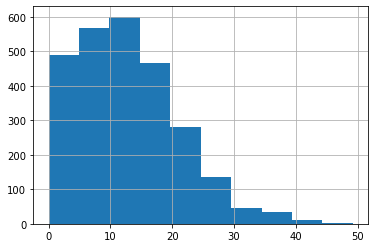

In [128]:
y_hat = best_rand.predict(X)
df = pd.DataFrame({'y': y, 'y_hat': y_hat})
p_df = abs(df['y']-df['y_hat']).hist()